In [ ]:
import keras
from keras.applications.vgg16 import VGG16
# from keras.applications.resnet50 import ResNet50
# from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [ ]:
train_dir = "/content/drive/MyDrive/ASL/ASL_dataset/training_set"
eval_dir = "/content/drive/MyDrive/ASL/ASL_dataset/test_set"

In [ ]:
#Helper function to load images from given directories
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

In [ ]:
uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(directory = eval_dir)

In [ ]:
len(images)

60352

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  40
Number of training images:  48281
Number of testing images:  12071
Number of evaluation images:  8000


In [ ]:
uniq_labels

['1',
 '10',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'best of luck',
 'fuck you',
 'i love you',
 'space']

In [ ]:
# one hot encoding
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [ ]:
print(y_train[1])
print(len(y_train[1]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
40


In [ ]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

In [ ]:
#Initialising vgg16
classifier_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#don't train existing weights for vgg16
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [ ]:
classifier1 = classifier_vgg16.output #head mode
classifier1 = Flatten()(classifier1) #adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.6)(classifier1)
classifier1 = Dense(units=40, activation='softmax')(classifier1)

model = Model(inputs = classifier_vgg16.input , outputs = classifier1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
#fit the model
#it will take some time to train
history = model.fit(X_train, y_train, epochs =5, batch_size = 64,validation_data=(X_test,y_test))

Epoch 1/5
755/755 [==============================] - 36s 32ms/step - loss: 0.2650 - accuracy: 0.9453 - val_loss: 0.0022 - val_accuracy: 0.9999
Epoch 2/5
755/755 [==============================] - 22s 29ms/step - loss: 0.0131 - accuracy: 0.9988 - val_loss: 7.7947e-04 - val_accuracy: 1.0000
Epoch 3/5
755/755 [==============================] - 22s 29ms/step - loss: 0.0061 - accuracy: 0.9994 - val_loss: 6.0219e-05 - val_accuracy: 1.0000
Epoch 4/5
755/755 [==============================] - 22s 30ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 3.1291e-05 - val_accuracy: 1.0000
Epoch 5/5
755/755 [==============================] - 23s 30ms/step - loss: 0.0053 - accuracy: 0.9989 - val_loss: 2.8293e-05 - val_accuracy: 1.0000


In [ ]:
# Saving the model of vgg16
model.save('model_vgg16.h5')

In [ ]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 100.0 %
Accuracy for evaluation images: 100.0 %


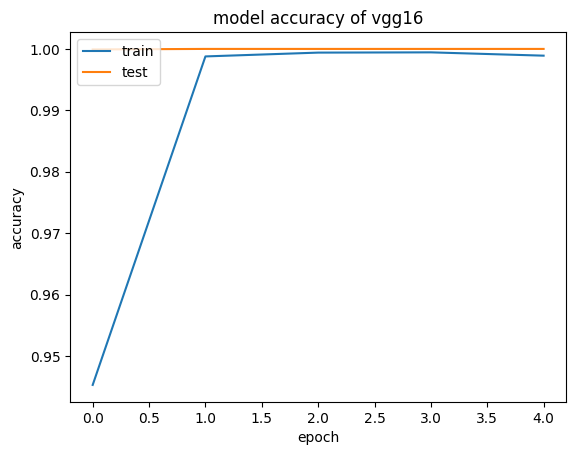

In [ ]:
#vgg16
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


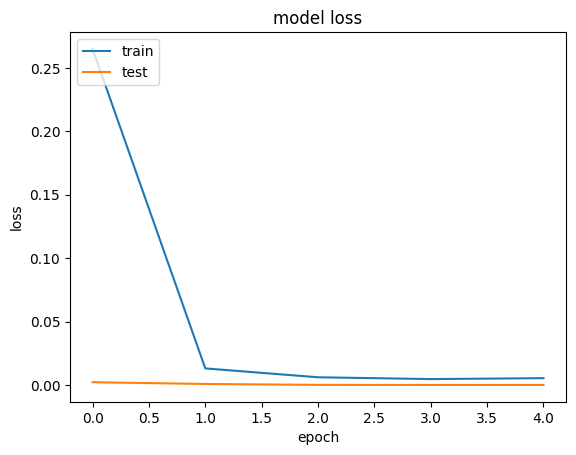

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
#plot_confusion_matrix(y_test, y_test_pred)

1/1 [==============================] - 0s 320ms/step
W


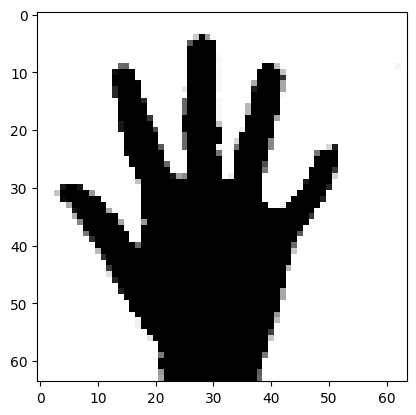

In [ ]:
import numpy as np
import keras.utils as image
test_image = image.load_img('/content/drive/MyDrive/ASL/ASL_dataset/test_set/5/1.png',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)


if result[0][0] == 1:
    prediction = '1'
elif result[0][1] == 1:
    prediction = '10'
elif result[0][2] == 1:
    prediction = '2'
elif result[0][3] == 1:
    prediction = '3'
elif result[0][4] == 1:
    prediction = '4'
elif result[0][5] == 1:
    prediction = '5'
elif result[0][6] == 1:
    prediction = '6'
elif result[0][7] == 1:
    prediction = '7'
elif result[0][8] == 1:
    prediction = '8'
elif result[0][9] == 1:
    prediction = '9'
elif result[0][10] == 1:
    prediction = 'A'
elif result[0][11] == 1:
    prediction = 'B'
elif result[0][12] == 1:
    prediction = 'C'
elif result[0][13] == 1:
    prediction = 'D'
elif result[0][14] == 1:
    prediction = 'E'
elif result[0][15] == 1:
    prediction = 'F'
elif result[0][16] == 1:
    prediction = 'G'
elif result[0][17] == 1:
    prediction = 'H'
elif result[0][18] == 1:
    prediction = 'I'
elif result[0][19] == 1:
    prediction = 'J'
elif result[0][20] == 1:
    prediction = 'K'
elif result[0][21] == 1:
    prediction = 'L'
elif result[0][22] == 1:
    prediction = 'M'
elif result[0][23] == 1:
    prediction = 'N'
elif result[0][24] == 1:
    prediction = 'O'
elif result[0][25] == 1:
    prediction = 'P'
elif result[0][26] == 1:
    prediction = 'Q'
elif result[0][27] == 1:
    prediction = 'R'
elif result[0][28] == 1:
    prediction = 'S'
elif result[0][29] == 1:
    prediction = 'T'
elif result[0][30] == 1:
    prediction = 'U'
elif result[0][31] == 1:
    prediction = 'V'
elif result[0][32] == 1:
    prediction = 'W'
elif result[0][33] == 1:
    prediction = 'X'
elif result[0][34] == 1:
    prediction = 'Y'
elif result[0][35] == 1:
    prediction = 'Z'
elif result[0][36] == 1:
    prediction = 'best of luck'
elif result[0][37] == 1:
    prediction = 'fuck you'
elif result[0][38] == 1:
    prediction = 'i love you'
else:
    prediction = '  '

print(prediction)